In [42]:
import numpy as np
import pandas as pd
import seaborn as sbn
import pickle as pkl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log


def eval_probs(y_prob,y_test, labels):
    """
    y_prob : predict_proba output of a model
    labels : all unique labels in the classification
    """
    
    vals = []
    titles = {}
    titles[-1] = "Away Win"
    titles[0] = "Draw"
    titles[1] = "Home Win"

    y_prob = pd.DataFrame(y_prob, columns=[-1, 0, 1])
    y_prob = y_prob.round(1)
    y_prob['label'] = y_test.reset_index(drop=True)
    
    for ind, label in enumerate(labels):
        vals = sorted(y_prob[label].unique())
        
        y_col = []
        
        
        for i in vals:
            tot_len = y_prob[(y_prob[label] == i)].shape[0]
            matching_len = y_prob[(y_prob[label] == i) & (y_prob['label'] == label)].shape[0]
            y_col.append(matching_len*1.0/tot_len)
        
#         print vals
#         print y_col
#         y.append(y_col)
        
        plt.figure(figsize=(10,16))
        plt.subplot(311+ind)
        plt.bar(vals, y_col, width=0.05)
        plt.title(titles[label], fontsize=16)
        plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=15)
        plt.yticks(fontsize=15)
        plt.show()
        
def save_model(model, model_name):
    saved_models_root = "./saved_models/" 
    filename = saved_models_root + model_name + datetime.now().strftime('%m%d_%H%M%S') + ".pkl"
                                                 
    with open(filename, 'wb') as outfile:
        pkl.dump(model, outfile)

In [43]:
# with open("./data/train_data.pkl") as infile:
#     train_data = pkl.load(infile)

with open("./data/train/train_data.pkl") as infile:
    train_data = pkl.load(infile)


In [44]:
train_data.columns.values

array(['season', 'stage', 'date', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_player_X1', 'home_player_X2',
       'home_player_X3', 'home_player_X4', 'home_player_X5',
       'home_player_X6', 'home_player_X7', 'home_player_X8',
       'home_player_X9', 'home_player_X10', 'home_player_X11',
       'away_player_X1', 'away_player_X2', 'away_player_X3',
       'away_player_X4', 'away_player_X5', 'away_player_X6',
       'away_player_X7', 'away_player_X8', 'away_player_X9',
       'away_player_X10', 'away_player_X11', 'home_player_Y1',
       'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'away_player_Y1', 'away_player_Y2',
       'away_player_Y3', 'away_player_Y4', 'away_player_Y5',
       'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'away_player_Y9', 'away_player_Y10', 'away_player_Y11',
     

In [4]:
columns = ['date', 'B365H', 'B365D', 'B365A', 'match_id', 'home_team', 'away_team', 
           'winner', 'minute', 'H_Goal', 'A_Goal']
train_data = train_data[columns]

In [5]:
train_data.shape

(183535, 11)

In [6]:
# train_data.match_id.value_counts()

In [7]:
# train_data[(train_data['match_id']==1510566245714) & (train_data['minute']>=45)]

In [8]:
train_data.drop_duplicates(inplace=True, keep='first')

In [9]:
# train_data.match_id.value_counts()

In [10]:
X = train_data.drop(['winner', 'date', 'match_id', 'home_team', 'away_team'], axis=1)
Y = train_data['winner']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

## Support Vector Classifier

In [92]:
svc = svm.SVC(probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = svc.predict_proba(X_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Logistic Regression

In [13]:
lr = LogisticRegression(n_jobs=-1,multi_class='multinomial',solver='lbfgs')
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = lr.predict_proba(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## SGD Classifier 

In [41]:
sgd = linear_model.SGDClassifier(loss='squared_epsilon_insensitive')
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = sgd.predict_proba(X_test)
eval_probs(y_prob,y_test, [-1, 0, 1])

0.257287705957


AttributeError: probability estimates are not available for loss='squared_epsilon_insensitive'

0.596903069378


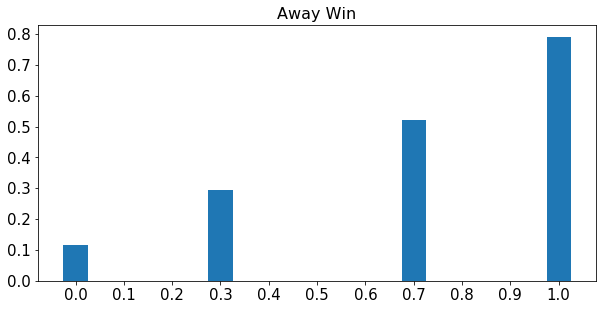

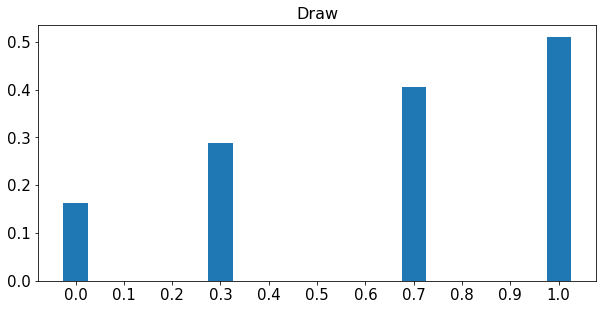

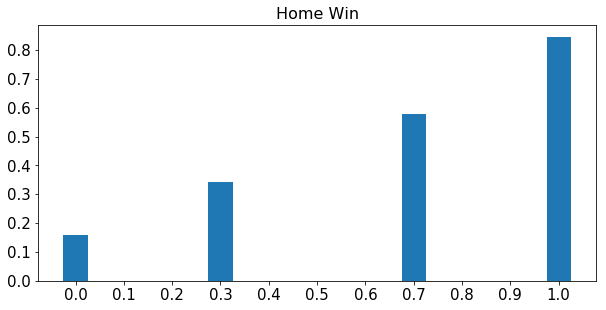

0.580371411253


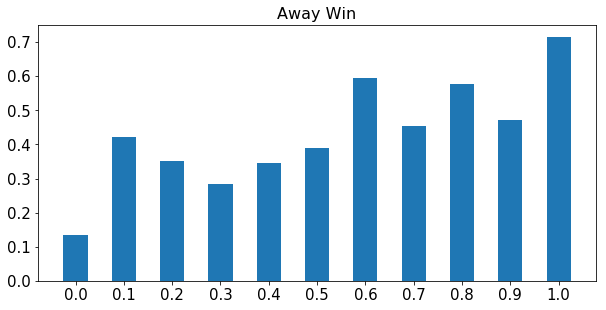

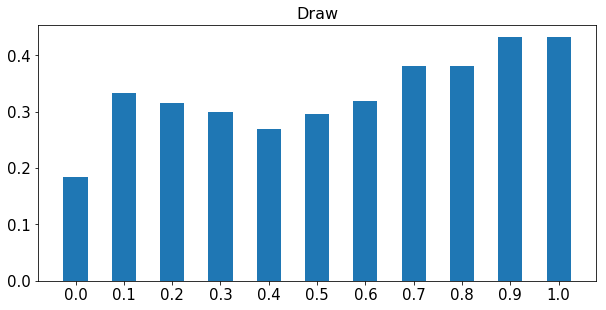

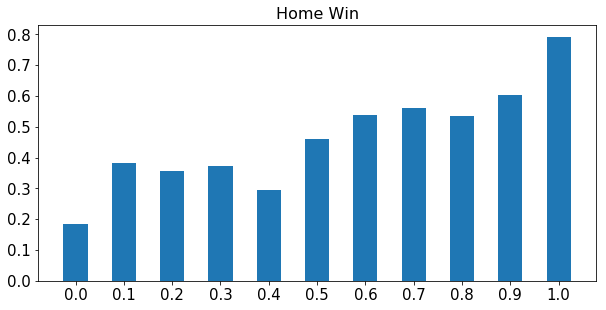

In [18]:

for weight in ['uniform', 'distance']:

    neigh = KNN(n_neighbors=3, algorithm='kd_tree', weights=weight, n_jobs=-1)
    neigh.fit(X_train, y_train) 
    
    y_pred = neigh.predict(X_test)

    print metrics.accuracy_score(y_test, y_pred)

    y_prob = neigh.predict_proba(X_test)
    eval_probs(y_prob, y_test, [-1,0,1])    
    
    
#     save_model(neigh, "KNN"+weight)